In [1]:
!pip install seaborn
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import torch
import torch.distributions as dist
from scipy.stats import beta
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from datetime import datetime
import copy
#%matplotlib notebook
random_seed = 1
np.random.seed(seed=1)
torch.manual_seed(2)
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
path = os.path.join(os.getcwd(), "plot/")
today=datetime.today().strftime('%Y-%m-%d')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class FHatNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FHatNetwork, self).__init__()
        layers = []
        if hidden_sizes == []:
            self.model = nn.Linear(input_size, output_size)
        else:
            layers.append(nn.Linear(input_size, hidden_sizes[0]))
            layers.append(nn.ReLU())
            for i in range(1, len(hidden_sizes)):
                layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
                layers.append(nn.ReLU())
            layers.append(nn.Linear(hidden_sizes[-1], output_size))
            self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)




# Define the target network
class TargetNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TargetNetwork, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.fc(x)

# Define the hypernetwork
class HyperNetwork(nn.Module):
    def __init__(self, target_net, hyper_input_dim, hyper_hidden_dims):
        super(HyperNetwork, self).__init__()
        self.target_net = target_net
        layers = [] 
        if hyper_hidden_dims == []:
            layers.append(nn.Linear(hyper_input_dim, target_net.fc.weight.numel()))
        else:
            layers.append(nn.Linear(hyper_input_dim, hyper_hidden_dims[0]))
            layers.append(nn.ReLU())
            for i in range(1, len(hyper_hidden_dims)):
                layers.append(nn.Linear(hyper_hidden_dims[i-1],hyper_hidden_dims[i]))
            layers.append(nn.Linear(hyper_hidden_dims[-1], target_net.fc.weight.numel()))
        
        layers.append(nn.Tanh())
        self.model = nn.Sequential(*layers)
        
    def forward(self, x, alpha):
        alpha = alpha.unsqueeze(0)
        params = self.model(alpha)
        params = params.view(self.target_net.fc.weight.size())
        self.target_net.fc.weight.data = params
        return self.target_net(x)

**Preliminaries** In the following, the classes are defined to initiate the aggregation functions $\rho_{\alpha}$ and the aggregated risk minimization (ARM) optimization for a simple 1D and 2D regression task.

In [6]:
class Quantile(torch.autograd.Function):

    @staticmethod
    def forward(ctx, risks, alpha):
        ctx.save_for_backward(risks, alpha)
        return torch.quantile(risks, alpha)

    @staticmethod
    def backward(ctx, grad_output):
        risks, alpha = ctx.saved_tensors
        diff = 1e-5
        grad_risks = grad_output * 0
        if alpha < diff:
            local_grad_alpha = (torch.quantile(risks, alpha+diff) - torch.quantile(risks, alpha))/diff
        elif alpha + diff > 1.0:
            local_grad_alpha = (torch.quantile(risks, alpha) - torch.quantile(risks, alpha-diff))/diff
        else:
            local_grad_alpha = (torch.quantile(risks, alpha+diff) - torch.quantile(risks, alpha-diff)) / (2.0 * diff)
        grad_alpha = grad_output * local_grad_alpha
        return grad_risks, grad_alpha
    
class aggregation_function:    
    """ This class aggregates the risks. """
    def __init__(self, name:str):
        self.name = name
    def aggregate(self, risks, alpha) -> float:
        if self.name == 'cvar':
            return self.cvar(risks, alpha)
        elif self.name == 'cvar-full':
            return self.cvar_full(risks, alpha)
        elif self.name == 'cvar-diff':
            return self.cvar_diff(risks, alpha)
        else:
            raise NotImplementedError("Currently, only CVaR is implemented.")
    
    def cvar_full(self, risks, alpha) -> float:
        var = torch.quantile(risks, alpha)
        cvar_plus = risks[risks >= var].mean()
        lambda_alpha = ((risks <= var_alpha).mean() - alpha) / (1 - alpha)
        cvar_alpha = lambda_alpha * var_alpha + (1 - lambda_alpha) * cvar_alpha_plus
        return cvar
    
    def cvar_diff(self, risks, base_alpha) -> float:
        number_of_points = 5
        alphas = [(1-base_alpha)*(i/number_of_points)+base_alpha for i in range(number_of_points)]
        quantiles = torch.stack([Quantile.apply(risks, alpha) for alpha in alphas])
        return quantiles.mean()
    
    def cvar(self, risks, alpha) -> float:
        var = torch.quantile(risks,alpha, interpolation='linear')
        cvar = risks[risks >= var].mean()
        return cvar

In [7]:
class IcdfBetaScaler(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, a, b):
        ctx.save_for_backward(x, a, b)
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        return torch.tensor(beta.ppf(x.item(), a.item(), b.item())).float().to(device)

    @staticmethod
    def backward(ctx, grad_output):
        x, a, b = ctx.saved_tensors
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        diff = 1e-5
        x = x.item()
        a = a.item()
        b = b.item()
        if x < diff:
            local_grad_x = torch.tensor([(beta.ppf(x+diff, a, b) - beta.ppf(x, a, b)) / diff]).float()
        elif x + diff > 1.0:
            local_grad_x = torch.tensor([(beta.ppf(x, a, b) - beta.ppf(x-diff, a, b)) / diff]).float()
        else:
            local_grad_x = torch.tensor([(beta.ppf(x+diff, a, b) - beta.ppf(x-diff, a, b)) / (2.0 * diff)]).float()

        if a < diff:
            local_grad_a = torch.tensor([(beta.ppf(x, a+diff, b) - beta.ppf(x, a, b)) / diff]).float()
        else:
            local_grad_a = torch.tensor([(beta.ppf(x, a+diff, b) - beta.ppf(x, a-diff, b)) / (2.0 * diff)]).float()

        if b < diff:
            local_grad_b = torch.tensor([(beta.ppf(x, a, b+diff) - beta.ppf(x, a, b)) / diff]).float()
        else:
            local_grad_b = torch.tensor([(beta.ppf(x, a, b+diff) - beta.ppf(x, a, b-diff)) / (2.0 * diff)]).float()
        grad_x = grad_output * local_grad_a.to(device)
        grad_a = grad_output * local_grad_a.to(device)
        grad_b = grad_output * local_grad_b.to(device)
        return grad_x, grad_a, grad_b
    
class Pareto_distribution:
    def __init__(self, env_dict):
        self.env_dict = env_dict
        self.loss_fn = torch.nn.MSELoss()
        self.aggregator = aggregation_function(name="cvar-diff")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    def compute_norm(self, model):
        # Calculate norm of gradients
        total_norm = 0
        for param in model.parameters():
            param_norm = param.grad.data.norm(2)
            total_norm += param_norm**2
        total_norm = total_norm ** 0.5
        return total_norm
    
    def aggregated_objective(self, model, a, b, num_samples=5):
        ### reparameterization needed here.
        uniform_samples = dist.Uniform(0,1).sample((num_samples,))
        alphas = []
        for unif_sample in uniform_samples:
            t_unif = torch.tensor(unif_sample, requires_grad=True, device=self.device)
            alphas.append(IcdfBetaScaler.apply(t_unif, a, b))
        cvar_estimates = []
        for alpha in alphas:
            risks = []
            for e in self.env_dict.keys():
                x, y = self.env_dict[e]['x'].to(self.device), self.env_dict[e]['y'].to(self.device) 
                x.requires_grad, y.requires_grad = False, False
                risks.append(self.loss_fn(y, model(x,alpha)))
            risks = torch.stack(risks)
            risks.requires_grad=False
            cvar_estimates.append(self.aggregator.aggregate(risks, alpha))
        cvar_estimates = torch.stack(cvar_estimates)
        average_cvar = torch.mean(cvar_estimates)
        return average_cvar
    
    def optimize(self, model):
        for param in model.parameters():
            param.requires_grad = False
        a = torch.tensor([1.0], requires_grad=True, device=self.device, dtype=torch.float32)
        b = torch.tensor([1.0], requires_grad=True, device=self.device, dtype=torch.float32)
        optimizer_dist = torch.optim.Adam([a, b], lr=0.01)
        num_epochs = 10
        for epoch in range(num_epochs):
            avg_cvar = self.aggregated_objective(model, a, b)
            avg_cvar.backward()
            optimizer_dist.step()
            optimizer_dist.zero_grad()
        return a.detach().item(), b.detach().item()

In [8]:
class ARM_Regression:
    def __init__(self, name, experiment="1D_linear"):      
        self.aggregator = aggregation_function(name=name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def compute_cvar_h(self, alpha, h, env_dict):
        loss_fn = torch.nn.MSELoss()        
        risks = []
        for e in env_dict.keys():
            output = h(env_dict[e]['x'].to(self.device), alpha.to(self.device))
            risks.append(loss_fn(output,env_dict[e]['y'].to(self.device)))
        risks = torch.stack(risks)
        cvar = self.aggregator.aggregate(risks, alpha)
        return cvar
    
    def fit_h(self, h, env_dict, num_epochs=100):
        loss_fn = torch.nn.MSELoss()
        alphas = np.random.beta(a=1, b=1, size=5) 
        alphas = torch.tensor(alphas, dtype=torch.float32).to(self.device)
        learning_rate = 0.03
        optimizer = torch.optim.Adam(h.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=10, gamma=0.9)
        for epoch in range(num_epochs):
            avg_cvar = torch.mean(torch.stack([self.compute_cvar_h(alpha, h, env_dict) for alpha in alphas]))
            avg_cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_cvar.item()}")
        return 
    
    def fit_h_pareto(self, h, env_dict, num_epochs=50):
        loss_fn = torch.nn.MSELoss()
        learning_rate = 0.03
        optimizer = torch.optim.Adam(h.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=10, gamma=0.9)
        p_min = Pareto_distribution(env_dict)
        for epoch in range(num_epochs):
            a, b = p_min.optimize(copy.deepcopy(h))
            alphas = np.random.beta(a, b, size=5) 
            alphas = torch.tensor(alphas, dtype=torch.float32).to(self.device)
            avg_cvar = torch.mean(torch.stack([self.compute_cvar_h(alpha, h, env_dict) for alpha in alphas]))
            avg_cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_cvar.item()}")
        return

**Experiment 1** We assume the following *linear* data generation process $$Y(X) = X*\theta_{e}+\epsilon$$ and *nonlinear* data generation process $$Y(X) = sin(X*\theta_{e})+\epsilon$$.

**Experiment 1A** Assume a linear model $Y_{e}=\theta_{e}X+\epsilon$, where $X \sim \mathcal{N}(2,0.2)$ and $\epsilon\sim \mathcal{N}(0,0.1)$. We simulate different environments by drawing $\theta$ from a beta distribution $Beta(0.1,0.2)$. In total, we generate for 25 environments 100 observations each.

**Experiment 1B** Assume the same setting as in Experiment 1, however, in contrast, we simulate different environments by drawing $\theta$ from a uniform distribution $\ \mathcal{U}(0,1)$. In total, we generate for 25 environments 100 observations each.

In [9]:
class data_generator:
    
    """ This class generates the simulation data. """
    

    def __init__(self, envs_train = 25, envs_test = 25, 
                 size_train = 1000, size_test= 100, 
                 theta_dist="uniform",
                 dim=1):
        
        self.envs_train = envs_train
        self.envs_test = envs_test
        self.size_train = size_train
        self.size_test = size_test
        self.theta_dist = theta_dist
        self.dim = dim 
        
    def generate(self) -> dict:           
        env_list_train = [f'e_{i}' for i in range(1,self.envs_train+1,1)]
        env_dict_train = dict(list(enumerate(env_list_train)))
        env_list_test  = [f'e_{i}' for i in range(1,self.envs_test+1,1)]
        env_dict_test  = dict(list(enumerate(env_list_test)))
        
        
        for e_train in env_dict_train.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(0, 1)
            else:
                distribution = dist.Beta(0.1, 0.2)
            theta_true = distribution.sample((self.dim,1))
            x_train = dist.normal.Normal(loc=1.0/self.dim, scale=0.5).sample((self.size_train,self.dim))
            noise_train = dist.normal.Normal(loc=0, scale=0.1).sample((self.size_train,self.dim))
            y_train = (1.0/math.sqrt(self.dim))*x_train@theta_true + noise_train
            env_dict_train[e_train] = {'x': x_train,'y': y_train,'theta_true': theta_true}
            
        for e_test in env_dict_test.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(0, 1)
            else:
                distribution = dist.Beta(0.1, 0.2)
            theta_true = distribution.sample((self.dim,1))
            x_test = dist.normal.Normal(loc=1.0/self.dim, scale=0.5).sample((self.size_test,self.dim))
            noise_test = dist.normal.Normal(loc=0, scale=0.1).sample((self.size_test,self.dim))
            y_test = (1.0/math.sqrt(self.dim))*x_test@theta_true + noise_test
            env_dict_test[e_test] = {'x': x_test,'y': y_test,'theta_true': theta_true}
            
        return env_dict_train, env_dict_test

In [10]:
# Instantiate the target network and hypernetwork
dim = 1
target_net = TargetNetwork(input_dim=dim, output_dim=1)
h = HyperNetwork(target_net, hyper_input_dim=1, hyper_hidden_dims=[10]).to(device)
print(h.target_net.fc.weight.data.item())

0.22939014434814453


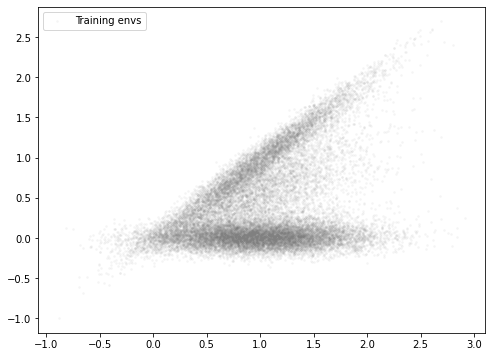

In [11]:
# Intitialize the experiment and generate the data
envs_train, envs_test = 250, 250
size_train, size_test = 100 , 100
theta_dist="beta" 
rho="cvar"

generator = data_generator(envs_train, envs_test, size_train, size_test, theta_dist, dim)
data_dict_train, data_dict_test = generator.generate()
# Define some example dimensions
generator = data_generator(envs_train, envs_test, size_train, size_test, theta_dist, dim)
data_dict_train, data_dict_test = generator.generate()
fig, ax = plt.subplots(1,1, figsize=(8,6))

X_train = [data_dict_train[e]['x'].ravel() for e in data_dict_train.keys()]
X_train = np.array([item for sublist in X_train for item in sublist]).reshape(-1,1)
Y_train = [data_dict_train[e]['y'] for e in data_dict_train.keys()]
Y_train = np.array([item for sublist in Y_train for item in sublist]).reshape(-1,1)

ax.scatter(y=Y_train, x=X_train, s=3, c="grey", alpha=0.05, label="Training envs")
ax.legend(loc='upper left')

Epoch [1/50], Loss: 0.3378290832042694
Epoch [2/50], Loss: 0.3317083716392517
Epoch [3/50], Loss: 0.3409941792488098
Epoch [4/50], Loss: 0.3105165958404541
Epoch [5/50], Loss: 0.32532966136932373
Epoch [6/50], Loss: 0.34561797976493835
Epoch [7/50], Loss: 0.3181917667388916
Epoch [8/50], Loss: 0.34261801838874817
Epoch [9/50], Loss: 0.3382425606250763
Epoch [10/50], Loss: 0.31808680295944214
Epoch [11/50], Loss: 0.316458523273468
Epoch [12/50], Loss: 0.29533231258392334
Epoch [13/50], Loss: 0.34179896116256714
Epoch [14/50], Loss: 0.311644583940506
Epoch [15/50], Loss: 0.3416483402252197
Epoch [16/50], Loss: 0.3121853470802307
Epoch [17/50], Loss: 0.32742005586624146
Epoch [18/50], Loss: 0.32011210918426514
Epoch [19/50], Loss: 0.29068437218666077
Epoch [20/50], Loss: 0.31775781512260437
Epoch [21/50], Loss: 0.29987090826034546
Epoch [22/50], Loss: 0.35210472345352173
Epoch [23/50], Loss: 0.3100927472114563
Epoch [24/50], Loss: 0.33349570631980896
Epoch [25/50], Loss: 0.311968028545379

  0%|          | 0/20 [00:00<?, ?it/s]

alpha:  tensor(0.)  CVaR:  0.24396751821041107 param:  0.13534677028656006
alpha:  tensor(0.0500)  CVaR:  0.25589480996131897 param:  0.14188309013843536
alpha:  tensor(0.1000)  CVaR:  0.26693564653396606 param:  0.14840708673000336
alpha:  tensor(0.1500)  CVaR:  0.27829790115356445 param:  0.15491816401481628
alpha:  tensor(0.2000)  CVaR:  0.28778380155563354 param:  0.16141580045223236
alpha:  tensor(0.2500)  CVaR:  0.29634931683540344 param:  0.167899489402771
alpha:  tensor(0.3000)  CVaR:  0.3033560514450073 param:  0.1743687093257904
alpha:  tensor(0.3500)  CVaR:  0.31055063009262085 param:  0.18082289397716522
alpha:  tensor(0.4000)  CVaR:  0.31733250617980957 param:  0.18726153671741486
alpha:  tensor(0.4500)  CVaR:  0.32457199692726135 param:  0.19368413090705872
alpha:  tensor(0.5000)  CVaR:  0.33105072379112244 param:  0.20009015500545502
alpha:  tensor(0.5500)  CVaR:  0.33733853697776794 param:  0.20647911727428436
alpha:  tensor(0.6000)  CVaR:  0.34366127848625183 param:  0

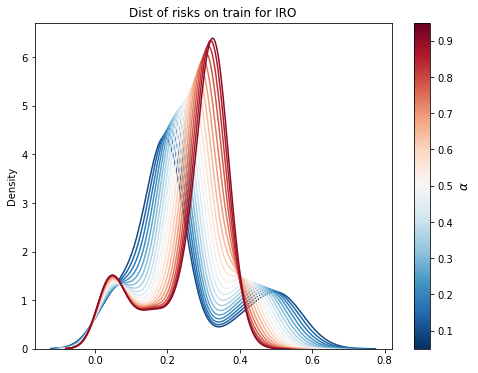

In [14]:
#Run the ARM regression task
loss_fn = torch.nn.MSELoss()
results = pd.DataFrame(columns = ["alpha", "cvar"])
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,6))
rg = torch.arange(0,0.96,0.05)
diverging_colors = sns.color_palette("RdBu", len(rg))
ARM_Regression(name=rho).fit_h_pareto(h, data_dict_train) 
h.eval()
j=1
for alpha in tqdm(rg):
    with torch.no_grad():
        risks = torch.stack([loss_fn(data_dict_train[e]['y'].to(device), h(data_dict_train[e]['x'].to(device), alpha.to(device))) for e in data_dict_train.keys()])
        cvar_emp = aggregation_function(name="cvar").aggregate(risks.cpu(), alpha.cpu())     
        sns.kdeplot(risks.cpu().numpy(), ax=ax,color=diverging_colors[len(rg)-j], label=str(alpha.item()))
        print("alpha: ", alpha, " CVaR: ",cvar_emp.item(), "param: ",h.target_net.fc.weight.data.item() )
    results.at[int(alpha.item()*100), "alpha"] = alpha
    results.at[int(alpha.item()*100), "cvar"] = cvar_emp
    j+=1
ax.legend(bbox_to_anchor=(1.02, 1.02), title=r"$\lambda$", loc='upper left')
ax.set_title(r"Risk Profiles wrt $\lambda$ for IRO")
norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])
ax.get_legend().remove()
ax.figure.colorbar(sm).set_label(label= r'$\alpha$',labelpad=5,size=12)

  0%|          | 0/20 [00:00<?, ?it/s]

alpha:  tensor(0.)  CVaR:  0.25419947504997253 param:  0.13534677028656006
alpha:  tensor(0.0500)  CVaR:  0.2668825089931488 param:  0.14188309013843536
alpha:  tensor(0.1000)  CVaR:  0.27883380651474 param:  0.14840708673000336
alpha:  tensor(0.1500)  CVaR:  0.2897702753543854 param:  0.15491816401481628
alpha:  tensor(0.2000)  CVaR:  0.2975887358188629 param:  0.16141580045223236
alpha:  tensor(0.2500)  CVaR:  0.3050667345523834 param:  0.167899489402771
alpha:  tensor(0.3000)  CVaR:  0.31166401505470276 param:  0.1743687093257904
alpha:  tensor(0.3500)  CVaR:  0.3187101483345032 param:  0.18082289397716522
alpha:  tensor(0.4000)  CVaR:  0.3251509964466095 param:  0.18726153671741486
alpha:  tensor(0.4500)  CVaR:  0.33201029896736145 param:  0.19368413090705872
alpha:  tensor(0.5000)  CVaR:  0.33820757269859314 param:  0.20009015500545502
alpha:  tensor(0.5500)  CVaR:  0.34423187375068665 param:  0.20647911727428436
alpha:  tensor(0.6000)  CVaR:  0.3508717715740204 param:  0.21285055

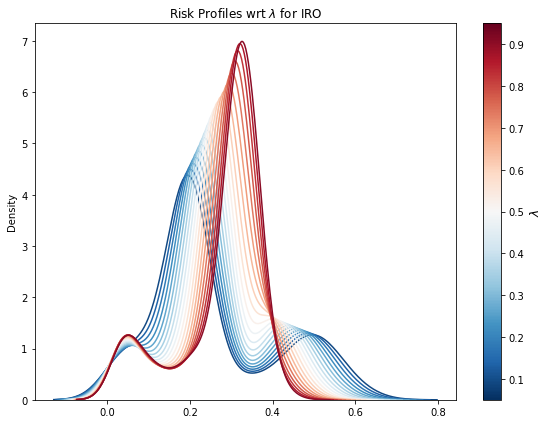

In [18]:
#Run the ARM regression task
loss_fn = torch.nn.MSELoss()
results = pd.DataFrame(columns = ["alpha", "cvar"])
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,6))
rg = torch.arange(0,1,0.05)
diverging_colors = sns.color_palette("RdBu", len(rg))
h.eval()
j=1
for alpha in tqdm(rg):
    with torch.no_grad():
        risks = torch.stack([loss_fn(data_dict_test[e]['y'].to(device), h(data_dict_test[e]['x'].to(device), alpha.to(device))) for e in data_dict_test.keys()])
        cvar_emp = aggregation_function(name="cvar").aggregate(risks.cpu(), alpha.cpu())     
        sns.kdeplot(risks.cpu().numpy(), ax=ax,color=diverging_colors[len(rg)-j], label=str(alpha.item()))
        print("alpha: ", alpha, " CVaR: ",cvar_emp.item(), "param: ",h.target_net.fc.weight.data.item() )
    results.at[int(alpha.item()*100), "alpha"] = alpha
    results.at[int(alpha.item()*100), "cvar"] = cvar_emp
    j+=1
ax.legend(bbox_to_anchor=(1.02, 1.02), title=r"$\lambda$", loc='upper left')
ax.set_title(r"Risk Profiles wrt $\lambda$ for IRO")
norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])
ax.get_legend().remove()
ax.figure.colorbar(sm).set_label(label= r'$\lambda$',labelpad=5,size=12)
plt.tight_layout()
plt.savefig("risk_distribution.pdf") 